In [1]:
import os, sys

directory = os.path.abspath('/Users/joris/Documents/Work/bsc ai/thesis/bachelor-thesis/code')
sys.path.append(directory)

from dataset.loading import DataLoader
from lib.conceptors import *
from lib.plotting.plotting_helpers import smoothed

import warnings
import gc
import numpy as np
import random

np.random.seed(0)
random.seed(0)
warnings.filterwarnings("ignore")

In [2]:
data_path = '../../'
cache_dir = '../cache/'
fc = DataLoader(data_path, cache_dir)

dr = []
speakers = []
XorZ = "X"
long_version = False
n_mels = 13
delta = False
delta_delta = False
subsamples = 10

path_option = "Final"+str(long_version)+str(n_mels)+str(delta)+str(delta_delta)+str(subsamples)

if dr:
    path_option = str(dr)+path_option
if len(speakers):
    path_option = str(len(speakers))+path_option

features_train, labels_train, _ = fc.collectFeaturesInSegments(
    n_mels=n_mels, delta=delta, delta_delta=delta_delta,
    long_version=long_version, speakers=speakers, dr=dr,
    subsamples=subsamples, path_option=path_option)

-from output
---- success


In [3]:
import librosa
from scipy.interpolate import CubicSpline

def getWavAndLabelInSegments(audio_path=None,phon_path=None,n_mels=n_mels,delta=True,
delta_delta=True,long_version=False,subsamples=10):
    """
    Returns
    - labels: a list of phonemes
    - feature_vectors: all corresponding sections of the signal
    """
    if audio_path == None:
        raise Exception("Path to audio (Wav) file must be provided")
    wav,sr = fc.read_audio(fpath=audio_path,pre_emp=True)

    audio_phon_transcription = None
    if phon_path == None:
        phon_path = fc.get_transcription_path_from_audio_path(audio_path)
    audio_phon_transcription = fc.read_transcription(phon_path)
    split_wav = []
    labels = []

    for idx, row in audio_phon_transcription.iterrows():
        split_wav.append( wav[row['start']:row['end']] )
        try:
            if long_version:
                phoneme = row['phoneme']
            else:
                phoneme = fc.get39EquiOf61(row['phoneme'])
        except:
            phoneme = 'h#'
        labels.append(phoneme)

    return split_wav,labels

def getFeatureAndLabelInSegments(audio_path=None,phon_path=None,n_mels=n_mels,delta=True,
delta_delta=True,long_version=False,subsamples=10):
    """
    Returns
    - labels: a list of phonemes
    - feature_vectors: all corresponding sections of the signal
    """
    oversamplings = 0
    if audio_path == None:
        raise Exception("Path to audio (Wav) file must be provided")
    wav,sr = fc.read_audio(fpath=audio_path,pre_emp=True)

    audio_phon_transcription = None
    if phon_path == None:
        phon_path = fc.get_transcription_path_from_audio_path(audio_path)
    audio_phon_transcription = fc.read_transcription(phon_path)
    split_wav = []
    labels = []

    for idx, row in audio_phon_transcription.iterrows():
        split_wav.append( wav[row['start']:row['end']] )
        try:
            if long_version:
                phoneme = row['phoneme']
            else:
                phoneme = fc.get39EquiOf61(row['phoneme'])
        except:
            phoneme = 'h#'
        labels.append(phoneme)

    feature_vectors = []

    for segment in split_wav:
        _,winlen,winstep = fc.getWindow(sr)
        db_melspec = librosa.feature.mfcc(segment,sr=sr,hop_length=winstep,win_length=winlen,n_mfcc=n_mels)

        mD = None
        mDD = None
        if(delta):
            width = db_melspec.shape[1] + db_melspec.shape[1] % 2 - 1 if db_melspec.shape[1] < 9 else 9
            mD = librosa.feature.delta(db_melspec, width=width)
            db_melspec = np.concatenate([db_melspec,mD])
            if(delta_delta):
                mDD = librosa.feature.delta(mD, width=width)
                db_melspec = np.concatenate([db_melspec,mDD])
        db_melspec = db_melspec.T

        if subsamples:
            if subsamples > db_melspec.shape[0]:
                oversamplings += 1
            cs = CubicSpline(np.arange(db_melspec.shape[0]), db_melspec)
            db_melspec = cs(np.linspace(0, db_melspec.shape[0], subsamples))
        feature_vectors.append( db_melspec )

    return feature_vectors,labels,oversamplings

In [4]:
# Plotting dataset
tddA = fc.get_audio_file_names('Train',speakers,dr)
tddA.index = range(tddA.shape[0])
feature_vectors = []
wav_vectors = []
labels = []


for i in range(20):
    wavs,lvs = getWavAndLabelInSegments(audio_path=tddA.loc[i]['path_from_data_dir'],n_mels=n_mels,
    delta=delta,delta_delta=delta_delta,long_version=long_version,subsamples=subsamples)
    
    fv,lv,_ = fc.getFeatureAndLabelInSegments(
        audio_path=tddA.loc[i]['path_from_data_dir'],n_mels=n_mels,
        delta=delta,delta_delta=delta_delta,long_version=long_version,
        subsamples=subsamples)

    for feature in fv:
        feature_vectors.append(np.asarray(np.array(feature,dtype=object)).astype(np.float32))
        
    for feature in wavs:
        wav_vectors.append(np.asarray(np.array(feature,dtype=object)).astype(np.float32))

    labels += lv
    normalize = True
    if normalize:
        extreme_val = max( [max(fv.max(), -fv.min()) for fv in feature_vectors] )
        feature_vectors = [ fv/extreme_val for fv in feature_vectors ]


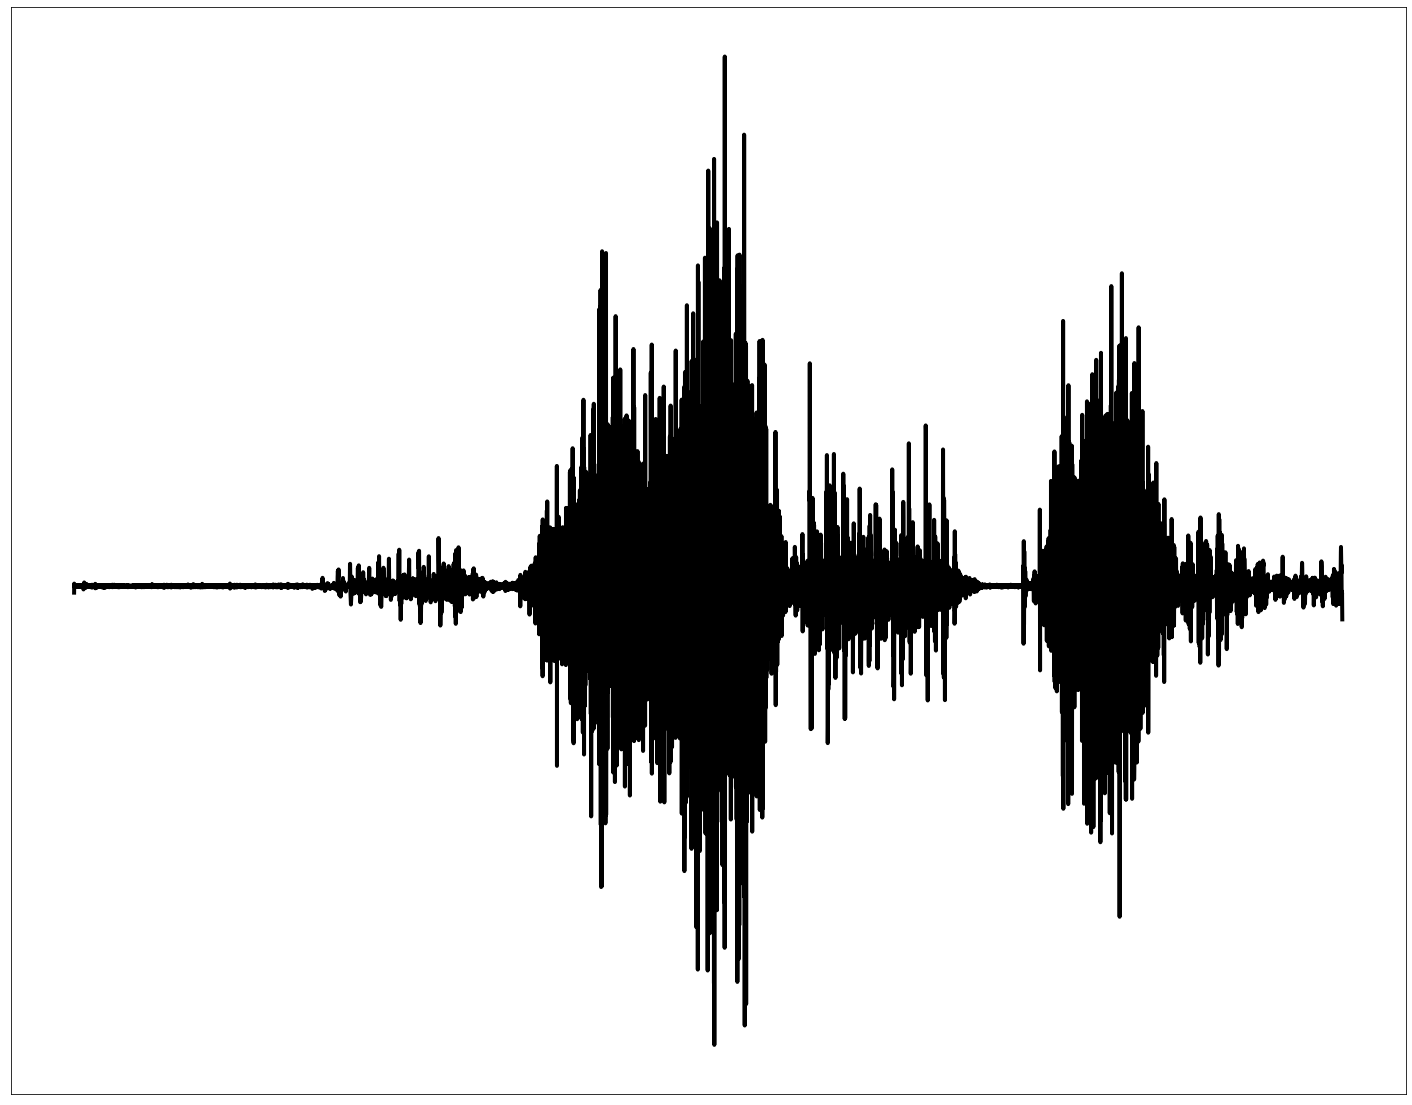

In [5]:
from matplotlib import pyplot as plt

wavs,lvs = getWavAndLabelInSegments(audio_path=tddA.loc[0]['path_from_data_dir'],n_mels=n_mels,
delta=delta,delta_delta=delta_delta,long_version=long_version,subsamples=subsamples)

wavs=wavs[:10]
lvs=lvs[:10]

#fig, ax = plt.subplots(figsize=(25,3),dpi=200)
fig, ax = plt.subplots(figsize=(25,20))

ship = 0
ticks = []
#for i, wav in enumerate(wavs):
#    plt.axvline(x=ship, color='orange')
#    lab = lvs[i]
#    pos = ship + len(wav) / 2
#    ship += len(wav)
#    ticks.append(pos)
#plt.axvline(x=ship, color='orange')
#ax.set_xticks(ticks)
#ax.set_xticklabels(lvs)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.plot(np.concatenate((wavs)), color='black', linewidth='4')
plt.show()

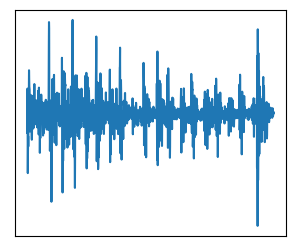

38 phonemes


In [6]:
groupwav = {}
groupmel = {}
for i in range(len(wav_vectors)):
    if labels[i] not in groupwav.keys():
        groupwav[labels[i]] = []
        groupmel[labels[i]] = []
    groupwav[labels[i]].append(wav_vectors[i])
    groupmel[labels[i]].append(feature_vectors[i])
phonemes = list(groupwav.keys())

fig, ax = plt.subplots(figsize=(3.5,3),dpi=100)
plt.plot(groupwav['iy'][2])#,label='/ah/ recording 2')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
#plt.legend(prop={'size': 16}, loc='upper right')
plt.show()

#fig, ax = plt.subplots(figsize=(3.5,3),dpi=200)
#plt.plot(groupmel['ah'][1])#,label='/ah/ recording 2')
#plt.legend(prop={'size': 16}, loc='upper right')
#plt.show()


print(str(len(phonemes))+" phonemes")
#[print(x," ss ",len(y)) for x,y in groupwav.items() ]


## PCA Visualization

In [ ]:
pcs = []
for C in Cs:
    U, s, _ = np.linalg.svd(C, hermitian=True, full_matrices=False)
    pcs.append(U[:,0])
pcs = np.asarray(pcs)

from sklearn.decomposition import PCA
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

print(pcs.shape)

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(pcs)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2','pc3'])
df = pd.DataFrame(data = phonemes)
print(principalDf)
finalDf = pd.concat([principalDf, df], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = Axes3D(fig)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalComponents[:,0], principalComponents[:,1],principalComponents[:,2])

for i, txt in enumerate(phonemes):
    a,b,c = principalComponents[i]
    ax.text(a,b,c,  txt, size=20, zorder=1,  color='k')
ax.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from math import floor
from matplotlib import gridspec

"""
Problem-specific plotting
"""
class Plot:
    def __init__(self, x, y):
        plt.rcParams["figure.autolayout"] = True
        self.fig = plt.figure(figsize=(y,x))
        self.cnt = 0
        self.new_ax = None

    def add(self, y, label=None):
        if label != None:
            self.new_ax.plot(y, label=label)
            self.new_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                                 ncol = 2, fancybox=True, shadow=True,
                                 handleheight=2.4, labelspacing=0.05)
        else:
            self.new_ax.plot(y)

    def inc(self):
        """Plots the data to a new subplot at the bottom."""
        self.cnt += 1
        gs = gridspec.GridSpec(self.cnt, 1)

        # Reposition existing subplots
        for i, ax in enumerate(self.fig.axes):
            ax.set_position(gs[i].get_position(self.fig))
            ax.set_subplotspec(gs[i])

        # Add new subplot
        self.new_ax = self.fig.add_subplot(gs[self.cnt-1])


    def add_new(self, y, label="No Label"):
        self.inc()
        self.add(y, label)

    def add_new_assignment_plot(self, assignments, labels=[], fuzzy=False, length=0):
        self.inc()
        for idx, ts in enumerate(assignments):
            if not fuzzy:
                y = []
                if length == 0:
                    length = max( [ max(ts) for ts in assignments if ts != [] ] )
                for t in range(length):
                    if t in ts:
                        y.append(1)
                    else:
                        y.append(0)
            else:
                y = ts
            if max(y) > 0:
                if labels == None:
                    self.add(smoothed(y,1))
                elif labels == []:
                    self.add(smoothed(y, 1), idx)
                else:
                    self.add(smoothed(y, 1), str(labels[idx]))


    def add_new_conceptors_fit_plot(self, X, Cs, Ns=None, label="", labels=""):
        """
        Plots, for each time step t, how well each conceptor in Cs matches the state x(t)
        """
        self.inc()
        if Ns:
            collection = evidences_for_Cs(X,Cs,Ns)
        else:
            collection, _ = test(X, Cs, "PROP")
        if labels:
            for vals, label in zip(collection, labels):
                # walking average of d
                self.add(smoothed(vals, 3), label=label)
        else:
            for i, vals in enumerate(collection):
                # walking average of d
                self.add(smoothed(vals, 3), label=label+str(i))


    def finalize(self, title=""):
        self.fig.suptitle(title, fontsize=16)
        plt.show()

In [ ]:
import librosa
from scipy.interpolate import CubicSpline

def getWavAndLabelInSegments(audio_path=None,phon_path=None,n_mels=15,delta=True,
delta_delta=True,long_version=False,subsamples=10):
    """
    Returns
    - labels: a list of phonemes
    - feature_vectors: all corresponding sections of the signal
    """
    oversamplings = 0
    if audio_path is None:
        raise Exception("Path to audio (Wav) file must be provided")
    wav, sr = fc.read_audio(fpath=audio_path, pre_emp=True)

    if phon_path is None:
        phon_path = fc.get_transcription_path_from_audio_path(audio_path)
    audio_phon_transcription = fc.read_transcription(phon_path)
    split_wav = []
    labels = []

    for _, row in audio_phon_transcription.iterrows():
        split_wav.append(wav[row['start']:row['end']])
        try:
            phoneme = row['phoneme']
            if not long_version:
                phoneme = fc.get_39_from_61(phoneme)
        except:
            phoneme = 'h#'
        labels.append(phoneme)

    return split_wav, labels

In [ ]:
# Plotting dataset
tddA = fc.getListAudioFiles('Test',speakers,dr)
tddA.index = range(tddA.shape[0])
feature_vectors = []
wav_vectors = []
labels = []


for i in range(20):
    wavs,lvs = getWavAndLabelInSegments(audio_path=tddA.loc[i]['path_from_data_dir'],n_mels=n_mels,
    delta=delta,delta_delta=delta_delta,long_version=long_version,subsamples=subsamples)

    fv,lv,_ = fc.getFeatureAndLabelInSegments(audio_path=tddA.loc[i]['path_from_data_dir'],n_mels=n_mels,
    delta=delta,delta_delta=delta_delta,long_version=long_version,subsamples=subsamples)

    for feature in fv:
        feature_vectors.append(np.asarray(np.array(feature,dtype=object)).astype(np.float32))

    for feature in wavs:
        wav_vectors.append(np.asarray(np.array(feature,dtype=object)).astype(np.float32))

    labels += lv
    normalize = True
    if normalize:
        extreme_val = max( [max(fv.max(), -fv.min()) for fv in feature_vectors] )
        feature_vectors = [ fv/extreme_val for fv in feature_vectors ]


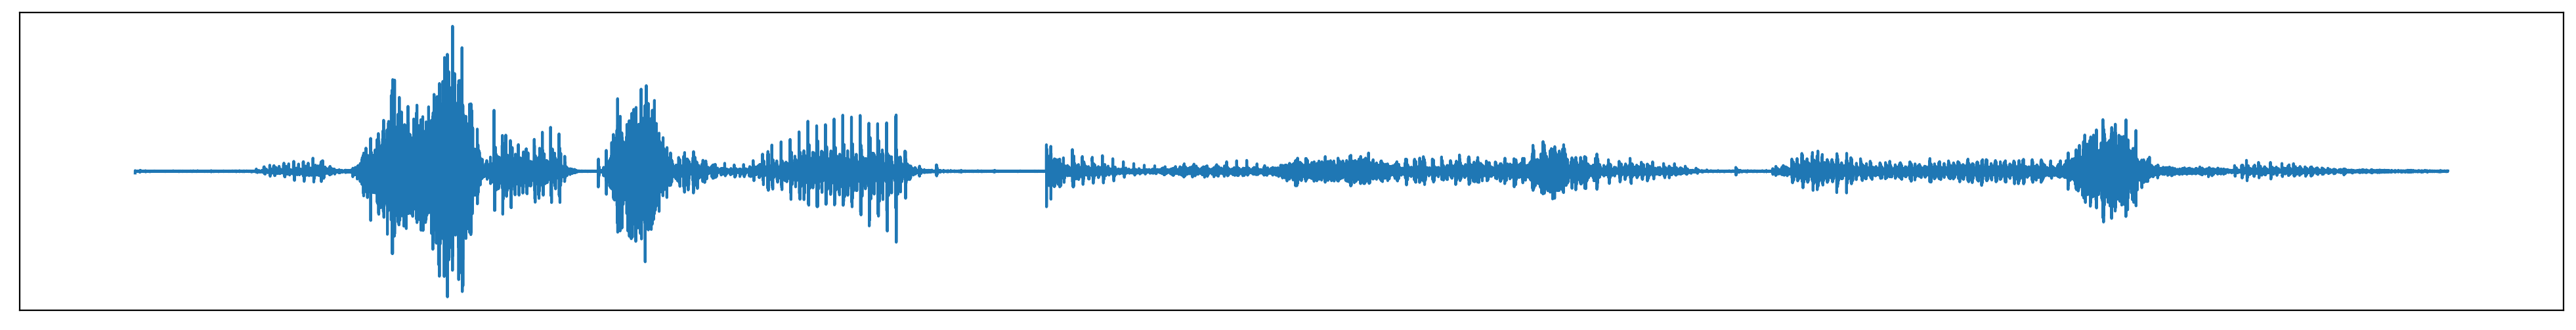

In [8]:

wavs,lvs = getWavAndLabelInSegments(audio_path=tddA.loc[0]['path_from_data_dir'],n_mels=n_mels,
delta=delta,delta_delta=delta_delta,long_version=long_version,subsamples=subsamples)

wavs=wavs[:35]
lvs=lvs[:35]


fig, ax = plt.subplots(figsize=(25,3),dpi=200)

ship = 0
ticks = []
#for i, wav in enumerate(wavs):
#    plt.axvline(x=ship, color='orange')
#    lab = lvs[i]
#    pos = ship + len(wav) / 2
#    ship += len(wav)
#    ticks.append(pos)
#plt.axvline(x=ship, color='orange')
#ax.set_xticks(ticks)
#ax.set_xticklabels(lvs)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.plot(np.concatenate((wavs)))
plt.show()

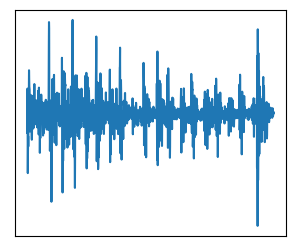

38 phonemes


In [7]:
groupwav = {}
groupmel = {}
for i in range(len(wav_vectors)):
    if labels[i] not in groupwav.keys():
        groupwav[labels[i]] = []
        groupmel[labels[i]] = []
    groupwav[labels[i]].append(wav_vectors[i])
    groupmel[labels[i]].append(feature_vectors[i])
phonemes = list(groupwav.keys())

fig, ax = plt.subplots(figsize=(3.5,3),dpi=100)
plt.plot(groupwav['iy'][2])#,label='/ah/ recording 2')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
#plt.legend(prop={'size': 16}, loc='upper right')
plt.show()

#fig, ax = plt.subplots(figsize=(3.5,3),dpi=200)
#plt.plot(groupmel['ah'][1])#,label='/ah/ recording 2')
#plt.legend(prop={'size': 16}, loc='upper right')
#plt.show()


print(str(len(phonemes))+" phonemes")
#[print(x," ss ",len(y)) for x,y in groupwav.items() ]
